## all the prices from Duke

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'Duke.xlsx'  # Replace with your file path
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Sort the data by 'PublishDate'
df = df.sort_values(by='PublishDate')

# Extract relevant date components
df['No'] = df.index + 1  # Add a row number (1-based index)
df['year'] = pd.to_datetime(df['PublishDate']).dt.year
df['month'] = pd.to_datetime(df['PublishDate']).dt.month
df['day'] = pd.to_datetime(df['PublishDate']).dt.day

# Extract the prepared data
prepared_data = df[['Y2', 'No', 'year', 'month', 'day', 'X1', 'X2', 'X3', 'X4', 'Y1']]

# Display the first few rows of the aggregated dataset
print(prepared_data.head())


     Y2  No  year  month  day     X1    X2       X3      X4    Y1
0  5.99   1  2014      1   10  5.288  3452  223.988  0.1205  5.49
1  5.99   2  2014      1   11  5.288  3452  223.988  0.1205  5.49
2  5.99   3  2014      1   12  5.288  3452  223.988  0.1205  5.49
3  5.99   4  2014      1   13  6.096  3452  223.988  0.1205  5.49
4  5.99   5  2014      1   14  6.579  3452  223.988  0.1205  5.49


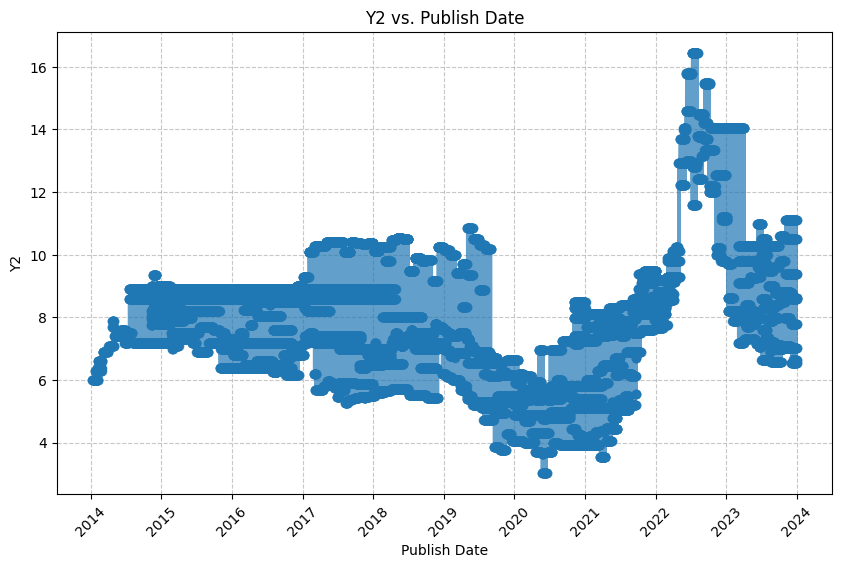

In [3]:
import matplotlib.pyplot as plt

# Convert PublishDate to datetime format
df["PublishDate"] = pd.to_datetime(df["PublishDate"])

# Check if 'Y2' exists in the dataframe
if "Y2" in df.columns:
    # Plot Y2 vs. PublishDate
    plt.figure(figsize=(10, 6))
    plt.plot(df["PublishDate"], df["Y2"], marker='o', linestyle='-', alpha=0.7)
    plt.xlabel("Publish Date")
    plt.ylabel("Y2")
    plt.title("Y2 vs. Publish Date")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Column 'Y2' not found in the dataset.")

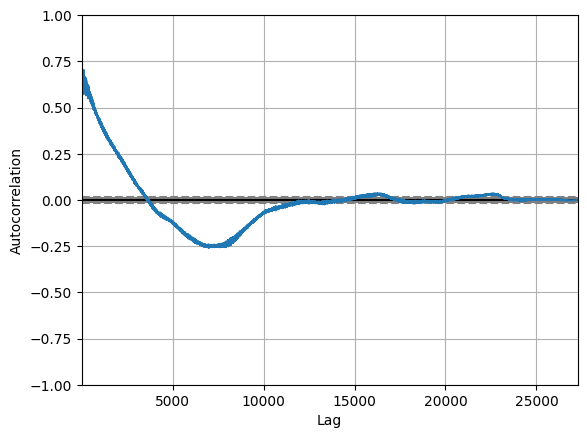

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# Check autocorrelation to see if step 365 is highly predictable from past data
autocorrelation_plot(prepared_data['Y2'])
plt.show()


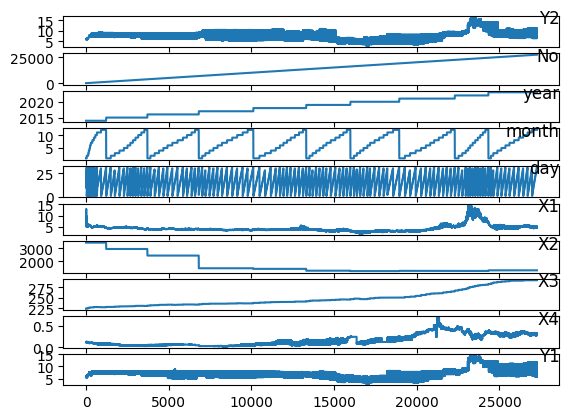

In [5]:
from matplotlib import pyplot

values = prepared_data.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(prepared_data.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [6]:
# prepare data for lstm
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = prepared_data
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
cols_to_drop = list(range(11, len(reframed.columns)))
reframed.drop(reframed.columns[cols_to_drop], axis=1, inplace=True)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.220731   0.000000        0.0        0.0   0.300000   0.257907   
2   0.220731   0.000037        0.0        0.0   0.333333   0.257907   
3   0.220731   0.000073        0.0        0.0   0.366667   0.257907   
4   0.220731   0.000110        0.0        0.0   0.400000   0.321634   
5   0.220731   0.000147        0.0        0.0   0.433333   0.359729   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1        1.0        0.0   0.139814    0.229113  0.220731  
2        1.0        0.0   0.139814    0.229113  0.220731  
3        1.0        0.0   0.139814    0.229113  0.220731  
4        1.0        0.0   0.139814    0.229113  0.220731  
5        1.0        0.0   0.139814    0.229113  0.220731  


In [7]:
# split into train and test sets
values = reframed.values
n_train = 21811
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(test)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[[0.46681583 0.8002861  0.777771   ... 0.6457847  0.49612403 0.48173004]
 [0.48173004 0.80039614 0.777771   ... 0.595619   0.51335055 0.40343022]
 [0.40343022 0.80021274 0.777771   ... 0.6457847  0.4013781  0.37807608]
 ...
 [0.41610736 0.9998533  1.         ... 0.38396296 0.32558137 0.41685307]
 [0.41685307 0.99989    1.         ... 0.38396296 0.32644272 0.47427297]
 [0.47427297 0.9999267  1.         ... 0.38396296 0.52196383 0.601044  ]]
(21811, 1, 10) (21811,) (5447, 1, 10) (5447,)


Epoch 1/50


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


303/303 - 2s - 7ms/step - loss: 0.0832 - val_loss: 0.1054
Epoch 2/50
303/303 - 1s - 2ms/step - loss: 0.0637 - val_loss: 0.0906
Epoch 3/50
303/303 - 0s - 2ms/step - loss: 0.0621 - val_loss: 0.0897
Epoch 4/50
303/303 - 0s - 1ms/step - loss: 0.0606 - val_loss: 0.0842
Epoch 5/50
303/303 - 0s - 1ms/step - loss: 0.0602 - val_loss: 0.0828
Epoch 6/50
303/303 - 0s - 1ms/step - loss: 0.0598 - val_loss: 0.0802
Epoch 7/50
303/303 - 0s - 2ms/step - loss: 0.0597 - val_loss: 0.0792
Epoch 8/50
303/303 - 1s - 2ms/step - loss: 0.0596 - val_loss: 0.0778
Epoch 9/50
303/303 - 0s - 1ms/step - loss: 0.0594 - val_loss: 0.0780
Epoch 10/50
303/303 - 0s - 1ms/step - loss: 0.0594 - val_loss: 0.0776
Epoch 11/50
303/303 - 0s - 1ms/step - loss: 0.0593 - val_loss: 0.0771
Epoch 12/50
303/303 - 0s - 2ms/step - loss: 0.0593 - val_loss: 0.0768
Epoch 13/50
303/303 - 0s - 1ms/step - loss: 0.0594 - val_loss: 0.0763
Epoch 14/50
303/303 - 0s - 1ms/step - loss: 0.0596 - val_loss: 0.0763
Epoch 15/50
303/303 - 0s - 1ms/step - lo

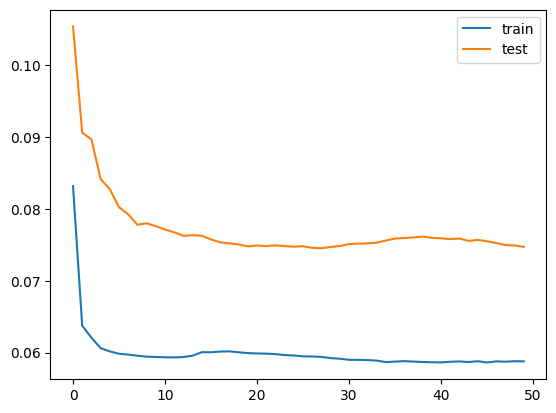

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
from math import sqrt
from numpy import concatenate

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test RMSE: 1.377


In [10]:
# calculate r2_score
r2 = r2_score(inv_y, inv_yhat)
print('Test r2_score: %.3f' % r2 )

Test r2_score: 0.666


In [11]:
inv_y

array([ 9.49,  8.44,  8.1 , ...,  8.62,  9.39, 11.09], dtype=float32)

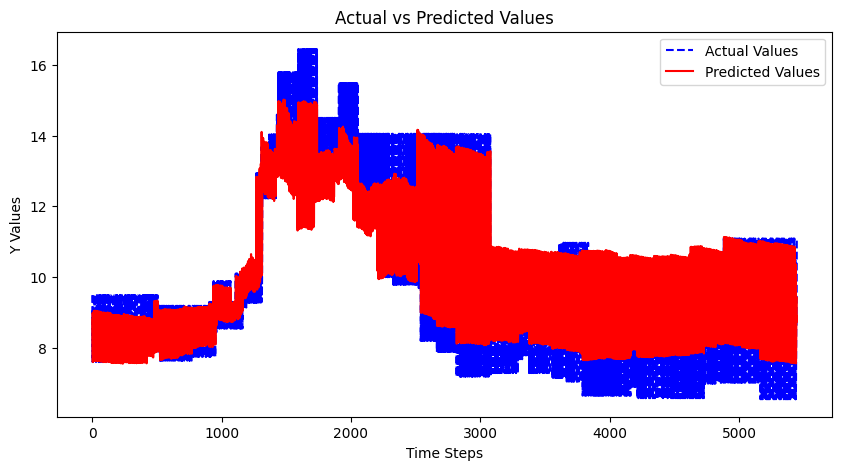

In [12]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(inv_y, label="Actual Values", color='blue', linestyle='dashed')
plt.plot(inv_yhat, label="Predicted Values", color='red')
plt.xlabel("Time Steps")
plt.ylabel("Y Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

## Performance metrics

In [3]:
## directional_accuracy

import numpy as np

def directional_accuracy_include_no_change(y_true, y_pred):
    """
    Computes the Directional Accuracy (DA) metric, including "no change" cases.

    Parameters:
    y_true (array-like): Actual values of the time series (can be 1D or 2D).
    y_pred (array-like): Predicted values of the time series (can be 1D or 2D).

    Returns:
    float: Directional Accuracy (proportion of correctly predicted directions)
    """
    # Flatten inputs if 2D
    y_true = np.ravel(y_true)  # Ensures a 1D array
    y_pred = np.ravel(y_pred)  # Ensures a 1D array

    if len(y_true) < 2 or len(y_pred) < 2:
        raise ValueError("Both y_true and y_pred must have at least two elements")

    # Compute the sign of changes
    actual_direction = np.sign(np.diff(y_true))  # Actual direction (1 = up, -1 = down, 0 = no change)
    predicted_direction = np.sign(np.diff(y_pred))  # Predicted direction (1, -1, or 0)

    # Compare predicted vs actual directions (including "no change" cases)
    correct_directions = actual_direction == predicted_direction

    # Compute directional accuracy
    da = np.mean(correct_directions) if len(correct_directions) > 0 else np.nan
    
    return da

In [4]:
## Mean Absolute Percentage Change Error (MAPCE)

import numpy as np

def evaluate_change_performance(y_true, y_pred):
    """
    Evaluates model performance based on the amount of change.

    Parameters:
    y_true (array-like): Actual values of the time series.
    y_pred (array-like): Predicted values of the time series.

    Returns:
    dict: Dictionary with MAPCE, correlation, and other metrics.
    """
    # Flatten inputs if 2D
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    if len(y_true) < 2 or len(y_pred) < 2:
        raise ValueError("Both y_true and y_pred must have at least two elements")

    # Compute changes (delta)
    delta_actual = np.diff(y_true)
    delta_predicted = np.diff(y_pred)
    
    # Remove zero-change cases from actual to avoid division errors
    valid_indices = delta_actual != 0
    delta_actual = delta_actual[valid_indices]
    delta_predicted = delta_predicted[valid_indices]

    # MAPCE (Mean Absolute Percentage Change Error)
    mapce = np.mean(np.abs((delta_actual - delta_predicted) / delta_actual)) * 100

    return mapce

### Example usage
y_actual = np.array([[6.99], [7.09], [8.59], [6.55], [7.89]])
y_predicted = np.array([[7.00], [7.10], [8.60], [6.50], [7.80]])

y_actual = np.array([100, 105, 105, 105, 105, 100]) 
y_predicted = np.array([100, 100, 106, 104, 100, 100]) 

da_score = directional_accuracy_include_no_change(y_actual, y_predicted)
print(f"Directional Accuracy (with no change cases): {da_score:.2%}")

mapce_score = evaluate_change_performance(y_actual, y_predicted)
print(f"Mean Absolute Percentage Change Error: {mapce_score:.2f}")

In [5]:
# Evaluation of Time-to-Next-Change

import numpy as np

def evaluate_time_to_next_change(y_true, y_pred):
    """
    Evaluates the model's ability to predict the time-to-next-change (m).

    Parameters:
    y_true (array-like): Actual values of the time series.
    y_pred (array-like): Predicted values of the time series.

    Returns:
    dict: Dictionary with MAE, RMSE, and timing accuracy metrics.
    """
    # Flatten inputs if 2D
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    def calculate_time_to_next_change(series):
        """
        Calculate the time-to-next-change (m) for each time step in a series.
        """
        time_to_next_change = []
        for i in range(len(series)):
            m = 1
            while i + m < len(series) and series[i] == series[i + m]:
                m += 1
            if i + m == len(series):  # No further changes
                m = np.inf
            time_to_next_change.append(m)
        return np.array(time_to_next_change)

    # Compute time-to-next-change for actual and predicted series
    m_actual = calculate_time_to_next_change(y_true)
    m_predicted = calculate_time_to_next_change(y_pred)
    # print(m_actual)
    # print(m_predicted)

    # Remove inf values (time steps with no further changes)
    valid_indices = np.isfinite(m_actual) & np.isfinite(m_predicted)
    m_actual = m_actual[valid_indices]
    m_predicted = m_predicted[valid_indices]
    # print(m_actual)
    # print(m_predicted)

    # Count of exact matches
    exact_match_count = np.sum(m_actual == m_predicted)
    total_valid = len(m_actual)
    exact_match_accuracy = exact_match_count / total_valid if total_valid > 0 else 0.0

    return {
        "Exact Match Count": exact_match_count,
        "Exact Match Accuracy": exact_match_accuracy
    }


### Example usage
y_actual = np.array([100, 100, 105, 105, 105, 100])
y_predicted = np.array([100, 100, 106, 104, 100, 100])

metrics = evaluate_time_to_next_change(y_actual, y_predicted)
print("Time-to-Next-Change Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

In [6]:
# Evaluation of directional accuracy with the correct Time-to-Next-Change

import numpy as np

def evaluate_directional_accuracy_after_correct_m(y_true, y_pred):
    """
    Evaluates the model's directional accuracy after correctly predicting time-to-next-change (m).

    Parameters:
    y_true (array-like): Actual values of the time series.
    y_pred (array-like): Predicted values of the time series.

    Returns:
    dict: Dictionary with metrics including directional accuracy after correct m.
    """
    # Flatten inputs if 2D
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    def calculate_time_to_next_change(series):
        """
        Calculate the time-to-next-change (m) for each time step in a series.
        """
        time_to_next_change = []
        for i in range(len(series)):
            m = 1
            while i + m < len(series) and series[i] == series[i + m]:
                m += 1
            if i + m == len(series):  # No further changes
                m = np.inf
            time_to_next_change.append(m)
        return np.array(time_to_next_change)

    # Compute time-to-next-change for actual and predicted series
    m_actual = calculate_time_to_next_change(y_true)
    m_predicted = calculate_time_to_next_change(y_pred)

    # Identify indices where m is correctly predicted
    correct_m_indices = np.where((m_actual == m_predicted) & (np.isfinite(m_actual)))[0]

    # Compute directional accuracy for correctly predicted m
    correct_direction_count = 0
    total_correct_m = len(correct_m_indices)

    for i in correct_m_indices:
        # Ensure we can calculate the direction (avoid index errors)
        if i + int(m_actual[i]) < len(y_true):
            actual_direction = np.sign(y_true[i + int(m_actual[i])] - y_true[i])
            predicted_direction = np.sign(y_pred[i + int(m_predicted[i])] - y_pred[i])
            if actual_direction == predicted_direction:
                correct_direction_count += 1

    # Directional Accuracy (DA) after correct m
    directional_accuracy = correct_direction_count / total_correct_m if total_correct_m > 0 else np.nan

    return {
        "Total Correct m": total_correct_m,
        "Directional Accuracy After Correct m": directional_accuracy
    }


### Example usage
y_actual = np.array([100, 100, 105, 105, 105, 100])
y_predicted = np.array([100, 100, 99, 104, 100, 100])

metrics = evaluate_directional_accuracy_after_correct_m(y_actual, y_predicted)
print("Performance Metrics After Correct m:")
for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

In [7]:
# Evaluation of Mean absolute percentage change error  with the correct Time-to-Next-Change

import numpy as np

def evaluate_mapce_after_correct_m(y_true, y_pred):
    """
    Evaluates the model's Mean Absolute Percentage Change Error (MAPCE) 
    after correctly predicting time-to-next-change (m).

    Parameters:
    y_true (array-like): Actual values of the time series.
    y_pred (array-like): Predicted values of the time series.

    Returns:
    dict: Dictionary with metrics including MAPCE after correct m.
    """
    # Flatten inputs if 2D
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    def calculate_time_to_next_change(series):
        """
        Calculate the time-to-next-change (m) for each time step in a series.
        """
        time_to_next_change = []
        for i in range(len(series)):
            m = 1
            while i + m < len(series) and series[i] == series[i + m]:
                m += 1
            if i + m == len(series):  # No further changes
                m = np.inf
            time_to_next_change.append(m)
        return np.array(time_to_next_change)

    # Compute time-to-next-change for actual and predicted series
    m_actual = calculate_time_to_next_change(y_true)
    m_predicted = calculate_time_to_next_change(y_pred)

    # Identify indices where m is correctly predicted
    correct_m_indices = np.where((m_actual == m_predicted) & (np.isfinite(m_actual)))[0]

    # Compute MAPCE for correctly predicted m
    percentage_errors = []
    for i in correct_m_indices:
        # Ensure valid indexing
        if i + int(m_actual[i]) < len(y_true):
            actual_change = y_true[i + int(m_actual[i])] - y_true[i]
            predicted_change = y_pred[i + int(m_predicted[i])] - y_pred[i]
            
            # Avoid division by zero for percentage error
            if actual_change != 0:
                percentage_error = np.abs((actual_change - predicted_change) / actual_change) * 100
                percentage_errors.append(percentage_error)

    # Compute MAPCE
    mapce = np.mean(percentage_errors) if len(percentage_errors) > 0 else np.nan

    return {
        "Total Correct m": len(correct_m_indices),
        "MAPCE After Correct m (%)": mapce
    }

## predict step 4

(27252, 40)
(21811, 30) 21811 (21811,)
(21811, 3, 10) (21811,) (5441, 3, 10) (5441,)
Epoch 1/50


c:\Users\ji.702\AppData\Local\anaconda3\envs\my-env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


303/303 - 2s - 7ms/step - loss: 0.0770 - val_loss: 0.0924
Epoch 2/50
303/303 - 1s - 2ms/step - loss: 0.0686 - val_loss: 0.0897
Epoch 3/50
303/303 - 1s - 2ms/step - loss: 0.0650 - val_loss: 0.0857
Epoch 4/50
303/303 - 1s - 2ms/step - loss: 0.0604 - val_loss: 0.0836
Epoch 5/50
303/303 - 1s - 2ms/step - loss: 0.0594 - val_loss: 0.0935
Epoch 6/50
303/303 - 1s - 2ms/step - loss: 0.0597 - val_loss: 0.1006
Epoch 7/50
303/303 - 1s - 2ms/step - loss: 0.0591 - val_loss: 0.0985
Epoch 8/50
303/303 - 1s - 2ms/step - loss: 0.0590 - val_loss: 0.1024
Epoch 9/50
303/303 - 1s - 2ms/step - loss: 0.0590 - val_loss: 0.1010
Epoch 10/50
303/303 - 1s - 3ms/step - loss: 0.0589 - val_loss: 0.1015
Epoch 11/50
303/303 - 1s - 2ms/step - loss: 0.0591 - val_loss: 0.1017
Epoch 12/50
303/303 - 1s - 2ms/step - loss: 0.0593 - val_loss: 0.0999
Epoch 13/50
303/303 - 1s - 2ms/step - loss: 0.0595 - val_loss: 0.0984
Epoch 14/50
303/303 - 1s - 2ms/step - loss: 0.0595 - val_loss: 0.0964
Epoch 15/50
303/303 - 1s - 2ms/step - lo

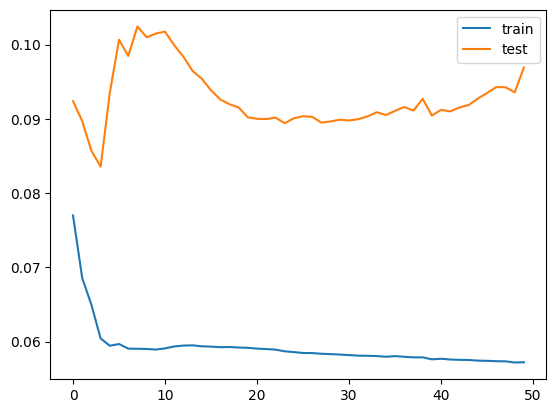

In [9]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = prepared_data
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag days
n_days = 3
n_features = 10
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)
 
# split into train and test sets
values = reframed.values
n_train_days = 21811
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [10]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate r2_score
r2 = r2_score(inv_y, inv_yhat)
print('Test r2_score: %.3f' % r2 )

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test RMSE: 1.740
Test r2_score: 0.468


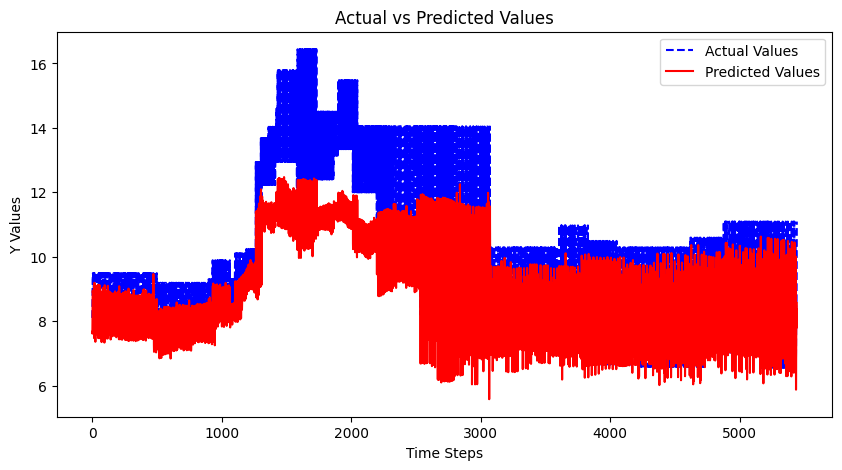

In [11]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(inv_y, label="Actual Values", color='blue', linestyle='dashed')
plt.plot(inv_yhat, label="Predicted Values", color='red')
plt.xlabel("Time Steps")
plt.ylabel("Y Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()